<h1>Veggie Tales!</h1>

Group members:
- Palaksh V Rungta
- Madison Hambly
- Felipe Lorenzi
- Jacob Schenberg

Dataset: https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition

Websites Cited/Referred To:

* https://gist.github.com/zed/4221180
* https://docs.python.org/3/library/os.html
* https://stackoverflow.com/questions/902761/saving-a-numpy-array-as-an-image
* https://stackoverflow.com/questions/48248405/cannot-write-mode-rgba-as-jpeg/48248432
* https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118

---

# Setup

In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns
from math import gcd
from PIL import Image
import cv2
import time
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [2]:
#improve plotting resolution
%config InlineBackend.figure_format ='retina'

---

# Exploration

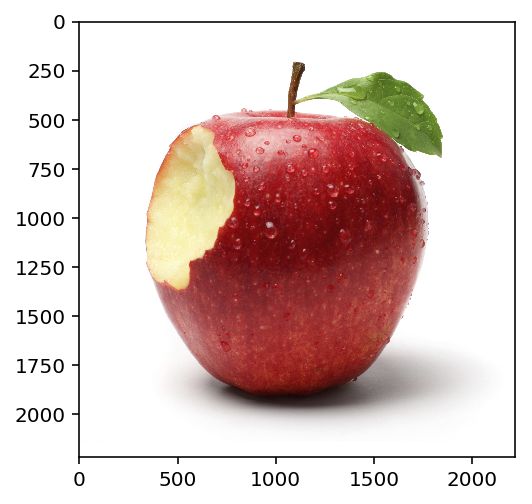

In [3]:
apple_1_fp = './train/apple/Image_1.jpg'
apple_1 = mpimg.imread(apple_1_fp)

plt.imshow(apple_1)

In [4]:
#Dimension of image are 2216 X 2218 with 3 color channels
apple_1.shape

(2216, 2218, 3)

Are the dimensions of every image the same?

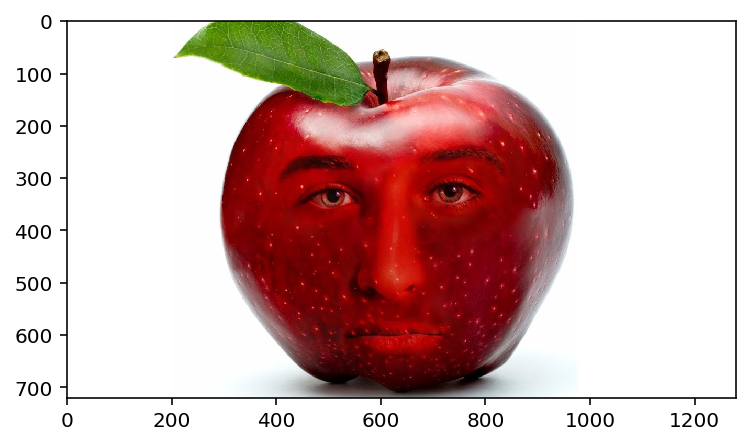

In [5]:
apple_fp = './train/apple/Image_18.jpg'
apple = mpimg.imread(apple_fp)

plt.imshow(apple)

In [6]:
apple.shape

(720, 1280, 3)

Doesn't look like it. We will have to crop/resize images

# Cropping and Resizing Images

As we want to perform PCA on our images dataset to reduce the dimensionality of the data, we must get all images to be the exact same size for our PCA algorithm.

To do this, we can crop images to be some aspect ratio, then resize them if needed. However, we have to pick which aspect ratio and size we want all of the images to be.

To find these values, we first look at the sizes of all the images in our dataset to see which aspect ratio and size would be most convenient:

In [81]:
def get_size_aspect_ratio(img):
    
    height = img.shape[0]
    width = img.shape[1]
    
    #GCD means greatest common divisor
    
    gcd_img = gcd(width, height) # using the math library
    aspect_ratio = (width / gcd_img, height / gcd_img) #i.e. aspect ratio of width / gcd : height / gcd
    width_height_ratio = width / height
    
    return [width, height, aspect_ratio, width_height_ratio]

In [ ]:
aspect_ratios = pd.DataFrame(columns = ['img_fp', 'width', 'height', 'aspect_ratio', 'width_height_ratio'])

train_dir = './train'
i = 0
for folder in os.listdir(train_dir):
    #Get folder filepath
    folder_dir = os.path.join(train_dir, folder)
    
    for img_file in os.listdir(folder_dir):
        
        #Get image filepath
        img_fp = os.path.join(folder_dir, img_file)
        
        #Read image to array
        try:
            img = mpimg.imread(img_fp)
        except:
            print('ERROR: ', img_fp)
        
        #Add data to dataframe
        aspect_ratios.loc[i] = [img_fp] + get_size_aspect_ratio(img)
        i += 1

In [ ]:
aspect_ratios

In [ ]:
aspect_ratios['aspect_ratio'].value_counts()[:10]

In [ ]:
sns.histplot(aspect_ratios['width'])
plt.show()

It looks like the most common aspect ratios are 1:1, 4:3 and 3:2. Furthermore, the most common image width is 1200.

Perhaps then it would be ideal to resize all the images to be 1200 x 1200, using the 1:1 aspect ratio.

EDIT: After trying using images at 1200 x 1200, we had to deal with memory issues due to the large size of the dataset. We decided then to reduce the images to 600 x 600. This means that the file sizes will be 1/4 of their original size, which will facilitate our work quite a bit.

In [8]:
# This snippet of code was inspired by https://gist.github.com/zed/4221180
# It was editted slightly to fit our problem

def crop_resize(image, size, ratio):
    
    
    image = Image.open(image)
    
    # crop to ratio, center
    w, h = image.size
    if w > ratio * h: # width is larger then necessary
        x, y = (w - ratio * h) // 2, 0
    else: # ratio*height >= width (height is larger)
        x, y = 0, (h - w / ratio) // 2
    image = image.crop((x, y, w - x, h - y))

    # resize
    image = image.resize(size)
    
    return image

### Testing on apple_1:

In [ ]:
apple_1_resized = np.array(crop_resize(apple_1_fp, (600, 600), 1))
plt.imshow(apple_1_resized)

In [ ]:
apple_1_resized.shape

Looks like it worked! The proportions of the apple have been preserved, the image is still fairly high-resolution and it has been reshaped correctly. 

Let's test this for a few different images to make sure.

Beetroot/Image_81 looks to be slightly off-center. Let's see how it looks after resizing:

In [ ]:
beetroot_81_resized = np.array(crop_resize('./train/beetroot/Image_81.jpg', (600, 600), 1))
plt.imshow(beetroot_81_resized)

In [ ]:
beetroot_81_resized.shape

The pomegranate is slightly off-center but this seems like a decent solution.

Beetroot/Image_86 is very small. Let's see how the resizing algorithm works in that case:

In [ ]:
beetroot_86_resized = np.array(crop_resize('./train/beetroot/Image_86.png', (600, 600), 1))
plt.imshow(beetroot_86_resized)

In [ ]:
beetroot_86_resized.shape

The image is not very clear, as is to be expected, but nothing weird is happening. This looks solid.

### Cropping and resizing all images and exporting them
Here we crop and resize all images to be 600 x 600, then export them to a new folder for posteriority.

We are making a new directory in repo for processed/recropped images. We are going to call this directory 'processed_train'.

We have already run the code below once to process the training images. We do not have to run this each time.

In [ ]:
'''
# looping through all subdirectories in train and making
# them in the processed_train folder
for i in os.walk('./train/'):
    
    path = i[0]
    path = path[0:2] + 'processed_600px_' + path[2:]
    
    # making directories
    os.makedirs(path)
'''

In [ ]:
'''# looping through subdirectories
for i in os.walk('./train/'):
    
    name = i[0]
    img_arr = i[2]
    
    for imgs in img_arr:
        orig_image_fp = name + '/' + imgs
        
        # obtaining the cropped version of the original image
        try:
            veg_cropped_arr = np.array(crop_resize(orig_image_fp, (600, 600), 1))
        except:
            print(f'Could not crop_resize: {orig_image_fp}')
            continue
        img_cropped_image = Image.fromarray(veg_cropped_arr) # gets image of np array

        # storing cropped image to new path
        new_fp = orig_image_fp[0:2] + 'processed_600px_' + orig_image_fp[2:]

        #  reducing the alpha channel (4th channel) in PNG to RGB only channels for JPG conversion
        img_cropped_image = img_cropped_image.convert('RGB')
        img_cropped_image.save(new_fp)
'''

Now, we should have all images in our processed_600px_train directory saved in 600 x 600 px dimension!

# PCA

To perform PCA on an RGB image (as opposed to greyscale images), we will need to obtain the 3 respective RGB channels and perform PCA seperately on them to reduce dimensions in each color channel. We use this [article](https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118): as a reference to split the channels.

In [9]:
app10 = cv2.imread('./processed_train/apple/Image_10.jpg')
app_arr = cv2.split(app10) # splits in BGR order not RGB

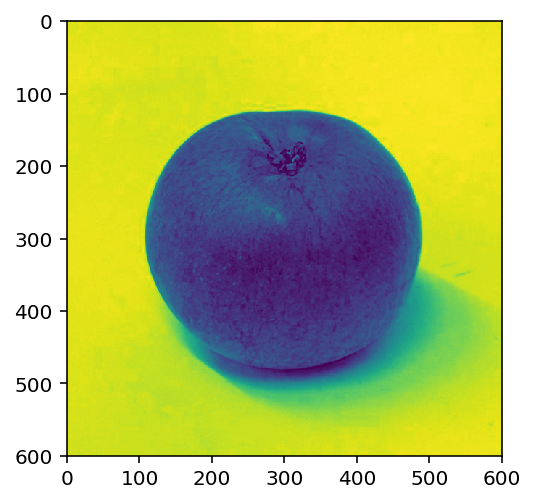

In [10]:
# displaying the blue channel
plt.imshow(app_arr[0])

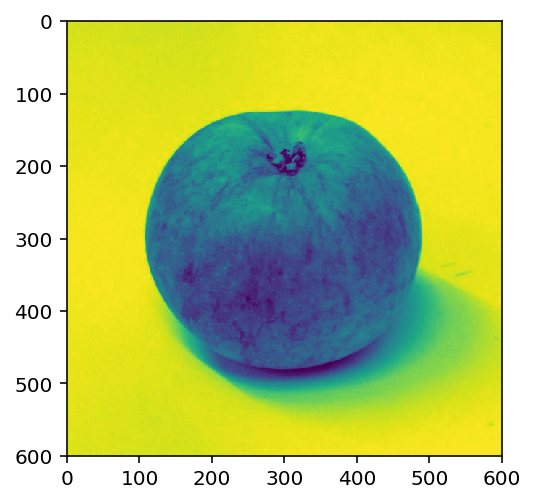

In [11]:
# displaying the green channel
plt.imshow(app_arr[1])

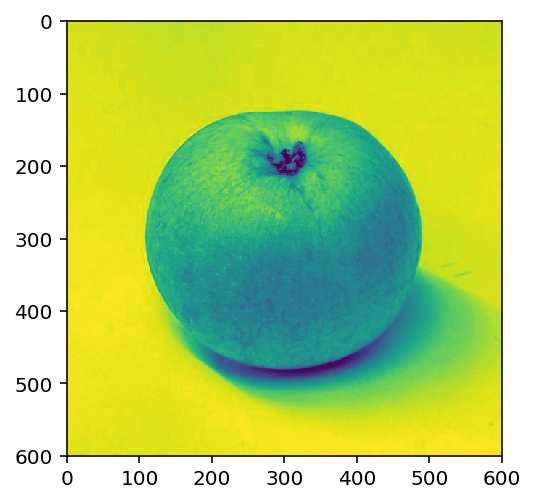

In [12]:
# displaying the red channel
plt.imshow(app_arr[2])

In [3]:
'''
Function takes in color channel of image and PCA dimensions to reduce to, and outputs the reduced channel array
'''
def PCA_transform_channel(channel, dim):
    channel_app = PCA(n_components = dim) # num dimensions
    channel_pca = channel_app.fit_transform(channel)
    return (channel_app, channel_pca)
    
def PCA_reduced_image_to_original_space(PCA_objects, image_pca):
    image = []
    for i in range(3):
        channel_pca = image_pca[:, i]
        channel_orig = PCA_objects[i].inverse_transform(channel_pca)
        image.append(channel_orig)
    return np.transpose(image, (1, 2, 0)) # Transpose image from shape (3, 600, 600) to shape (600, 600, 3)

In [4]:
'''
Function takes in image file path and PCA dimensions to reduce to, and outputs the reduced image
'''
def image_PCA_transform(img_fp, dim):
    
    # splitting RGB channels into 3 Np arrays
    cv_img = cv2.imread(img_fp)
    cv_img_arr = cv2.split(cv_img)
    
    PCA_objects = []
    new_channels = [] # will contain the reduced arrays
    
    for i in range(3):
        channel_PCA_object, new_channel = PCA_transform_channel(cv_img_arr[i], dim)
        PCA_objects.append(channel_PCA_object)
        new_channels.append(new_channel)
        
    merged_image = cv2.merge(new_channels)
    return PCA_objects, merged_image

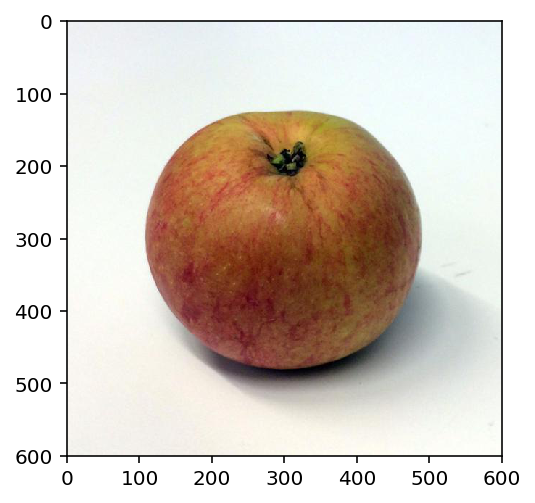

In [16]:
apple_image_fp = './processed_train/apple/Image_10.jpg'
apple_image_orig = mpimg.imread(apple_image_fp)
plt.imshow(apple_image_orig)

In [17]:
PCA_objects, apple_image_transformed = image_PCA_transform(apple_image_fp, 50)

In [18]:
apple_image_transformed.shape

(600, 50, 3)

# PCA on all training images

Let us run PCA on all training images. Let us convert each image to an array and then append that to a master list for each channel.

In [5]:
original_images_order = []

master_blue = []
master_green = []
master_red = []

# looping through subdirectories
for i in os.walk('./processed_600px_train/'):
    
    name = i[0]
    img_arr = i[2]
    
    for imgs in img_arr:
        orig_image_fp = name + '/' + imgs
        original_images_order.append(orig_image_fp)
        
        try:
            fruit = cv2.imread(orig_image_fp)
            fruit_arr = cv2.split(fruit) # splits in BGR order not RGB
        
            master_blue.append(fruit_arr[0] / 255)
            master_green.append(fruit_arr[1] / 255)
            master_red.append(fruit_arr[2] / 255)
            
        except:
            print('Error: ' + orig_image_fp)

Error: ./processed_600px_train//.DS_Store


We need to flatten the array for each image, which is currently of dimension 600 x 600. into an array of length 360,000 as PCA takes in a 2D array as input. 

That is, we will create a matrix of images of shape (495, 360,000), where each row is a flattened image and each column is a pixel location. We will create 3 of these matrices, one for each color channel of our images. Then, we will join these back together in order to re-create our images in a reduced space.

In [6]:
# Current shape of master arrays:
np.array(master_blue).shape

(495, 600, 600)

In [7]:
for i in range(len(master_blue)):
    master_blue[i] = master_blue[i].flatten()
    master_green[i] = master_green[i].flatten()
    master_red[i] = master_red[i].flatten()

In [23]:
# Shape of master arrays after flattening:
np.array(master_blue).shape

(495, 360000)

Running PCA on each master channel and saving them to txt:

In [7]:
N_reduced_dimensions = 130

In [ ]:
master_blue_pca_obj, master_blue_transformed = PCA_transform_channel(master_blue, N_reduced_dimensions)

a_file = open('master_blue.txt', 'w')

for row in master_blue_transformed:
    np.savetxt(a_file, row)
    
a_file.close()

In [ ]:
master_green_pca_obj, master_green_transformed = PCA_transform_channel(master_green, N_reduced_dimensions)

b_file = open('master_green.txt', 'w')

for row in master_green_transformed:
    np.savetxt(b_file, row)

b_file.close()

In [ ]:
master_red_pca_obj, master_red_transformed = PCA_transform_channel(master_red, N_reduced_dimensions)

c_file = open('master_red.txt', 'w')

for row in master_red_transformed:
    np.savetxt(c_file, row)

c_file.close()

In [ ]:
masters_transformed = np.array([master_red_transformed, master_green_transformed, master_blue_transformed])
masters_transformed = np.transpose(masters_transformed, (1, 2, 0))

In [ ]:
masters_transformed.shape

In [ ]:
np.save('./masters_transformed', masters_transformed)

Masters is now an array of all of our reduced images. If we want, we can take the 30 dimensions of each channel of a reduced image and transform it back to the original 600 x 600 space.

In [ ]:
reverted_masters = PCA_reduced_image_to_original_space([master_red_pca_obj, master_green_pca_obj, master_blue_pca_obj], 
                                   masters_transformed)

In [ ]:
i = np.random.randint(0, 496)
image_flat = reverted_masters[i, :, :]
image = image_flat.reshape((600, 600, 3))
plt.imshow(image)

---

# Clustering Algorithms after PCA Dimension Reduction

Writting a function that does the clustering algorithm of choice (k-means, spectral, and DB scan), to avoid re-using code.

In [8]:
masters_transformed = np.load('./masters_transformed.npy')
transformed_flat = masters_transformed.reshape((495, N_reduced_dimensions * 3))
transformed_flat.shape

(495, 390)

In [9]:
def perform_clustering(transformed_flat, cluster):
    
    cluster_obj = 0

    if cluster == 'k_means':
        print('Performing K-means Clustering')
        cluster_obj = KMeans(n_clusters = 5)
        cluster_obj.fit(transformed_flat)
    
    elif cluster == 'spectral_clustering':
        print('Performing Spectral Clustering')
        cluster_obj = SpectralClustering(n_clusters = 5)
        cluster_obj.fit(transformed_flat)
        
    else:
        print('Performing DB Scan')
        cluster_obj = DBSCAN(eps = 201)
        cluster_obj.fit(transformed_flat)
    
    labels = cluster_obj.labels_
    
    fruits = ['apple', 'bell pepper', 'cabbage', 'beetroot', 'banana']
    clusters = np.unique(labels)

    labels_per_fruit = {fruit : {cluster:0 for cluster in clusters} for fruit in fruits}

    for label, image_fp in zip(labels, original_images_order):

        try:
            fruit = image_fp.split('/')[2]
            labels_per_fruit[fruit][label] += 1

        except:
            print('Error in processing file path: ', image_fp)

    labels_per_fruit = pd.DataFrame.from_dict(labels_per_fruit, orient = 'index')

    return labels, labels_per_fruit

# K-means Clustering

In [10]:
k_means_labels, k_means_clusters = perform_clustering(transformed_flat, 'k_means')

Performing K-means Clustering
Error in processing file path:  ./processed_600px_train//.DS_Store


In [11]:
k_means_labels

array([0, 4, 1, 3, 1, 0, 3, 3, 1, 1, 2, 1, 1, 1, 2, 0, 0, 3, 0, 0, 1, 1,
       0, 0, 4, 2, 3, 1, 1, 0, 4, 0, 2, 2, 0, 0, 3, 0, 2, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 2, 0, 4, 1, 0, 3, 2, 1, 0, 3, 1, 0, 0, 4, 2,
       0, 2, 2, 0, 0, 0, 0, 3, 0, 0, 4, 4, 3, 0, 0, 2, 1, 1, 3, 0, 4, 1,
       4, 1, 2, 1, 1, 1, 2, 1, 3, 3, 2, 2, 0, 0, 2, 2, 2, 0, 4, 2, 2, 2,
       2, 1, 4, 0, 1, 0, 1, 2, 4, 0, 2, 0, 1, 4, 0, 0, 0, 4, 4, 4, 0, 2,
       0, 2, 2, 2, 2, 1, 3, 2, 4, 2, 1, 2, 4, 4, 4, 1, 1, 0, 0, 1, 2, 4,
       0, 1, 2, 2, 1, 2, 1, 4, 1, 2, 2, 2, 2, 4, 1, 0, 0, 2, 2, 0, 0, 4,
       1, 2, 2, 2, 0, 2, 2, 4, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 3, 1, 0,
       1, 0, 4, 1, 4, 4, 1, 4, 4, 4, 3, 1, 4, 4, 0, 1, 0, 1, 2, 4, 2, 3,
       1, 4, 2, 0, 4, 3, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 2, 1, 4, 4, 4,
       3, 1, 0, 1, 4, 4, 4, 4, 4, 2, 4, 4, 0, 0, 2, 4, 3, 0, 4, 4, 4, 4,
       4, 3, 4, 0, 4, 4, 4, 2, 4, 4, 0, 4, 4, 0, 4, 1, 4, 2, 2, 4, 4, 2,
       3, 4, 4, 4, 4, 4, 2, 4, 3, 4, 0, 2, 0, 2, 1,

In [12]:
k_means_clusters

,0,1,2,3,4
apple,34,28,16,13,9
bell pepper,26,19,36,2,17
cabbage,14,10,12,8,53
beetroot,25,19,41,6,9
banana,20,2,7,41,27


# DB Scan

In [14]:
db_labels, db_clusters = perform_clustering(transformed_flat, 'db_scan')

Performing DB Scan
Error in processing file path:  ./processed_600px_train//.DS_Store


In [15]:
db_labels

array([ 0, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
        0, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1,  0,  1, -1,  0,
       -1,  0, -1, -1,  1, -1, -1,  0,  0, -1, -1,  1,  0,  0, -1,  1, -1,
       -1,  0, -1, -1,  1

In [16]:
db_clusters

,-1,0,1,2,3
apple,82,1,16,1,0
bell pepper,92,5,2,1,0
cabbage,56,31,10,0,0
beetroot,95,2,3,0,0
banana,77,3,6,5,6


# Spectral Clustering after PCA

In [17]:
sc_labels, sc_clusters = perform_clustering(transformed_flat, 'spectral_clustering')

Performing Spectral Clustering
Error in processing file path:  ./processed_600px_train//.DS_Store


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  est = KMeans(


In [18]:
sc_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
sc_clusters

,0,1
apple,100,0
bell pepper,100,0
cabbage,97,0
beetroot,100,0
banana,95,2


Unfortunately, it looks like all apples, bell peppers, cabbages and beetroots got clustered into the same cluster. On the other hand, some bananas got clustered into different clusters.

---

# Visualizing fruits in K-means cluster sample

In [36]:
dict_images = {}
counter = 0

# looping through subdirectories
for i in os.walk('./processed_600px_train/'):
    
    name = i[0]
    img_arr = i[2]
        
    for imgs in img_arr:
        
        if counter == 495:
            break
        
        orig_image_fp = name + '/' + imgs
        
        if k_means_labels[counter] not in dict_images:
            dict_images[k_means_labels[counter]] = []
        
        dict_images[k_means_labels[counter]].append(orig_image_fp)
        counter += 1

In [ ]:
# viewing fruit images in cluster 2

for i in dict_images[2]:
    fruits_img = mpimg.imread(i)
    plt.imshow(fruits_img)
    plt.show()

In [ ]:
# visualizing the centers
center_0_r = master_red_pca_obj.inverse_transform(kmeans.cluster_centers_[0].reshape(130, 3)[:, 0])
center_0_g = master_green_pca_obj.inverse_transform(kmeans.cluster_centers_[0].reshape(130, 3)[:, 1])
center_0_b = master_blue_pca_obj.inverse_transform(kmeans.cluster_centers_[0].reshape(130, 3)[:, 2])

center_0 = np.array([center_0_r, center_0_g, center_0_b]).reshape(600, 600, 3)

In [ ]:
plt.imshow(center_0)

# Clustering after processing data

We noticed our dataset had a lot of 'unnatural' data. For example, under the fruit folder 'apple', we had images of animated apples, Apple brand logo, etc. We realized that this is probably tricking the clustering algorithm by adding noise. So we manually removed the unnatural images.

Now, let us try to perform PCA on the processed data using the code written above.

# PCA on cleaned Data

In [13]:
original_images_order = []

master_blue_nat = []
master_green_nat = []
master_red_nat = []

# looping through subdirectories
for i in os.walk('./processed_600px_train_natural/'):
    
    name = i[0]
    img_arr = i[2]
    
    for imgs in img_arr:
        orig_image_fp = name + '/' + imgs
        original_images_order.append(orig_image_fp)
        
        try:
            fruit = cv2.imread(orig_image_fp)
            fruit_arr = cv2.split(fruit) # splits in BGR order not RGB
        
            master_blue_nat.append(fruit_arr[0] / 255)
            master_green_nat.append(fruit_arr[1] / 255)
            master_red_nat.append(fruit_arr[2] / 255)
            
        except:
            print('Error: ' + orig_image_fp)

Error: ./processed_600px_train_natural//.DS_Store
Error: ./processed_600px_train_natural/apple/.DS_Store
Error: ./processed_600px_train_natural/bell pepper/.DS_Store
Error: ./processed_600px_train_natural/cabbage/.DS_Store
Error: ./processed_600px_train_natural/beetroot/.DS_Store
Error: ./processed_600px_train_natural/banana/.DS_Store


In [14]:
for i in range(len(master_blue_nat)):
    master_blue_nat[i] = master_blue_nat[i].flatten()
    master_green_nat[i] = master_green_nat[i].flatten()
    master_red_nat[i] = master_red_nat[i].flatten()

In [47]:
N_reduced_dimensions = 130

In [ ]:
master_blue_pca_obj, master_blue_transformed_nat = PCA_transform_channel(master_blue_nat, N_reduced_dimensions)

a_file = open('master_blue_natural.txt', 'w')

for row in master_blue_transformed_nat:
    np.savetxt(a_file, row)
    
a_file.close()

In [ ]:
master_green_pca_obj, master_green_transformed_nat = PCA_transform_channel(master_green_nat, N_reduced_dimensions)

b_file = open('master_green_natural.txt', 'w')

for row in master_green_transformed_nat:
    np.savetxt(b_file, row)

b_file.close()

In [ ]:
master_red_pca_obj, master_red_transformed_nat = PCA_transform_channel(master_red_nat, N_reduced_dimensions) 

c_file = open('master_red_natural.txt', 'w')

for row in master_red_transformed_nat:
    np.savetxt(c_file, row)

c_file.close()

In [ ]:
masters_transformed_nat = np.array([master_red_transformed_nat, master_green_transformed_nat, master_blue_transformed_nat])
masters_transformed_nat = np.transpose(masters_transformed_nat, (1, 2, 0))

In [ ]:
np.save('./masters_transformed_natural', masters_transformed_nat)

# Clustering algorithms on cleaned dataset

In [48]:
masters_transformed_nat = np.load('./masters_transformed_natural.npy')

# 378 is the number of natural images 
transformed_flat_nat = masters_transformed_nat.reshape((378, N_reduced_dimensions * 3))

# K-means Clustering

In [49]:
k_means_labels_nat, k_means_clusters_nat = perform_clustering(transformed_flat_nat, 'k_means')

Performing K-means Clustering
Error in processing file path:  ./processed_600px_train_natural//.DS_Store


In [50]:
k_means_labels_nat

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 4,
       0, 0, 1, 2, 0, 4, 0, 3, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 1,
       1, 0, 2, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 0, 0, 3, 0, 0, 3, 2, 3,
       3, 2, 1, 2, 0, 4, 0, 4, 2, 3, 2, 3, 2, 0, 0, 0, 2, 2, 2, 3, 3, 3,
       3, 1, 4, 3, 2, 0, 2, 3, 4, 0, 0, 4, 3, 0, 1, 0, 3, 4, 4, 2, 4, 2,
       2, 4, 1, 0, 3, 3, 0, 0, 4, 3, 3, 0, 3, 3, 2, 0, 0, 0, 0, 4, 1, 0,
       2, 2, 0, 0, 4, 4, 0, 4, 0, 2, 1, 2, 2, 4, 2, 2, 2, 1, 3, 2, 2, 0,
       1, 1, 2, 2, 3, 1, 4, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 3, 1,
       2, 2, 2, 4, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2,
       2, 3, 2, 1, 2, 2, 0, 0, 2, 1, 3, 3, 0, 3, 3, 2, 1, 2, 1, 3, 3, 1,
       1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 2, 3, 1, 0,
       2, 0, 3, 3, 1, 0, 2, 1, 1, 0, 0, 0, 2, 3, 0, 3, 3, 0, 1, 0, 3, 1,
       3, 3, 3, 0, 3, 1, 3, 3, 1, 1, 3, 0, 0, 0, 4,

In [51]:
k_means_clusters_nat

,0,1,2,3,4
apple,24,23,6,4,2
bell pepper,25,6,19,20,14
cabbage,11,11,54,6,4
beetroot,23,17,8,28,4
banana,12,1,20,1,34


# DB Scan

In [52]:
db_labels_nat, db_clusters_nat = perform_clustering(transformed_flat_nat, 'db_scan')

Performing DB Scan
Error in processing file path:  ./processed_600px_train_natural//.DS_Store


In [53]:
db_labels_nat

array([-1,  0, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
        0, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  2, -1,  1, -1, -1, -1, -1,  2, -1, -1,  1,
        1, -1,  2,  1, -1, -1,  2, -1, -1,  1, -1,  2,  1,  1, -1,  1, -1,
        1, -1, -1,  1, -1,  2, -1, -1,  1,  2, -1,  1,  2, -1,  1, -1,  1,
        1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,
        1, -1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1,  0,  1, -1

In [54]:
db_clusters_nat

,-1,0,1,2,3
apple,49,10,0,0,0
bell pepper,79,0,2,3,0
cabbage,51,1,27,7,0
beetroot,77,1,1,1,0
banana,58,0,1,3,6


# Spectral Clustering

In [55]:
sc_labels_nat, sc_clusters_nat = perform_clustering(transformed_flat_nat, 'spectral_clustering')

Performing Spectral Clustering
Error in processing file path:  ./processed_600px_train_natural//.DS_Store


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  est = KMeans(


In [56]:
sc_labels_nat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [57]:
sc_clusters_nat

,1,2,3,4
apple,59,0,0,0
bell pepper,84,0,0,0
cabbage,86,0,0,0
beetroot,80,0,0,0
banana,64,2,1,1


# Results

## Comparing Clustering Algorithms

## K-means

In [58]:
k_means_clusters

,0,1,2,3,4
apple,19,15,5,28,33
bell pepper,33,4,19,19,25
cabbage,10,8,55,10,14
beetroot,41,7,9,19,24
banana,6,43,27,1,20


In [59]:
k_means_clusters_nat

,0,1,2,3,4
apple,24,23,6,4,2
bell pepper,25,6,19,20,14
cabbage,11,11,54,6,4
beetroot,23,17,8,28,4
banana,12,1,20,1,34


In [70]:
def normalize_df(df):
    
    new_k_cluster = df.copy()

    for i in df:
        new_k_cluster[i] = df[i] / (df.sum(axis = 1))[i]
        
    return new_k_cluster

In [71]:
new_k_cluster = normalize_df(k_means_clusters)
new_k_cluster

,0,1,2,3,4
apple,0.19,0.15,0.051546,0.28,0.340206
bell pepper,0.33,0.04,0.195876,0.19,0.257732
cabbage,0.10,0.08,0.567010,0.10,0.144330
beetroot,0.41,0.07,0.092784,0.19,0.247423
banana,0.06,0.43,0.278351,0.01,0.206186


In [62]:
new_k_cluster_nat = normalize_df(k_means_clusters_nat)
new_k_cluster_nat

,0,1,2,3,4
apple,0.406780,0.273810,0.069767,0.0500,0.029412
bell pepper,0.423729,0.071429,0.220930,0.2500,0.205882
cabbage,0.186441,0.130952,0.627907,0.0750,0.058824
beetroot,0.389831,0.202381,0.093023,0.3500,0.058824
banana,0.203390,0.011905,0.232558,0.0125,0.500000


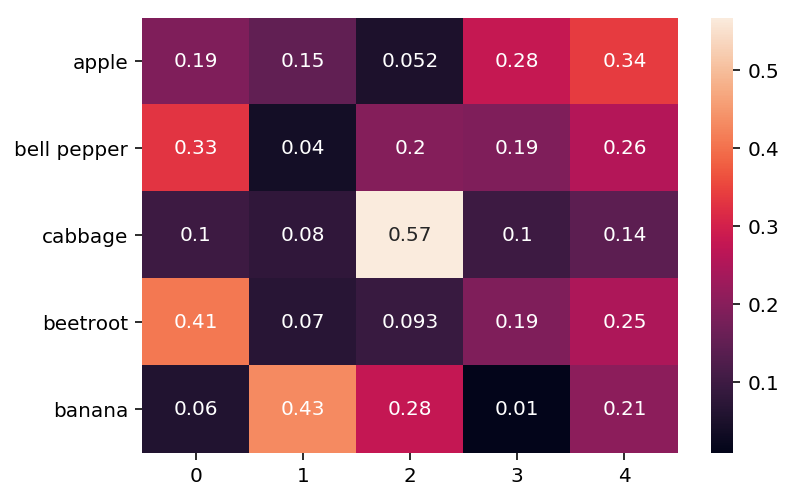

In [63]:
sns.heatmap(new_k_cluster, annot = True)

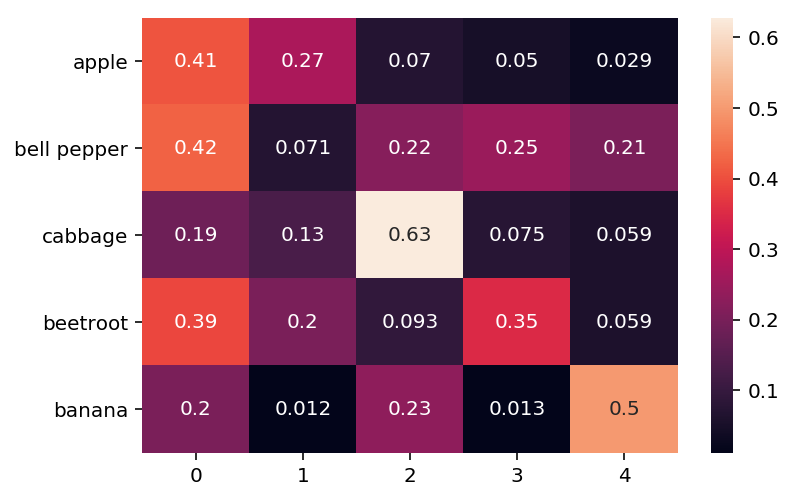

In [64]:
sns.heatmap(new_k_cluster_nat, annot = True)

## DB Scan

In [65]:
db_clusters

,-1,0,1,2,3
apple,82,1,16,1,0
bell pepper,92,5,2,1,0
cabbage,56,31,10,0,0
beetroot,95,2,3,0,0
banana,77,3,6,5,6


In [66]:
db_clusters_nat

,-1,0,1,2,3
apple,49,10,0,0,0
bell pepper,79,0,2,3,0
cabbage,51,1,27,7,0
beetroot,77,1,1,1,0
banana,58,0,1,3,6


In [73]:
new_db_cluster = normalize_df(db_clusters)
new_db_cluster

,-1,0,1,2,3
apple,0.845361,0.01,0.16,0.010309,0.00
bell pepper,0.948454,0.05,0.02,0.010309,0.00
cabbage,0.577320,0.31,0.10,0.000000,0.00
beetroot,0.979381,0.02,0.03,0.000000,0.00
banana,0.793814,0.03,0.06,0.051546,0.06


In [74]:
new_db_cluster_nat = normalize_df(db_clusters_nat)
new_db_cluster_nat

,-1,0,1,2,3
apple,0.720588,0.169492,0.000000,0.000000,0.000
bell pepper,1.161765,0.000000,0.023810,0.034884,0.000
cabbage,0.750000,0.016949,0.321429,0.081395,0.000
beetroot,1.132353,0.016949,0.011905,0.011628,0.000
banana,0.852941,0.000000,0.011905,0.034884,0.075


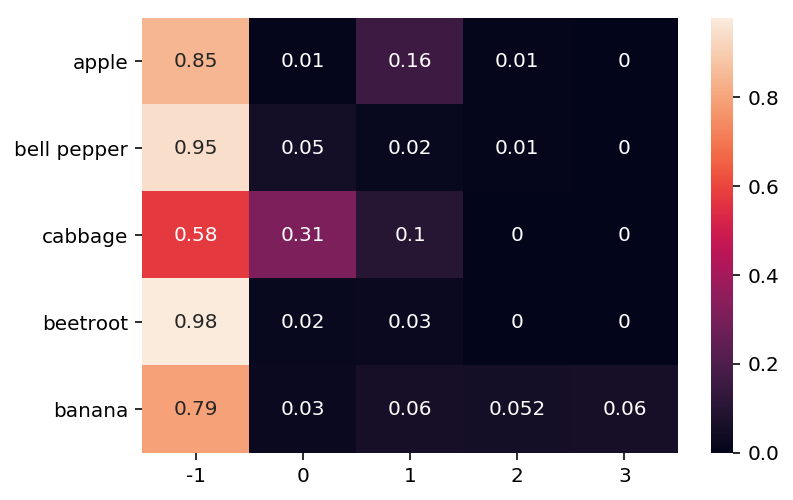

In [75]:
sns.heatmap(new_db_cluster, annot = True)

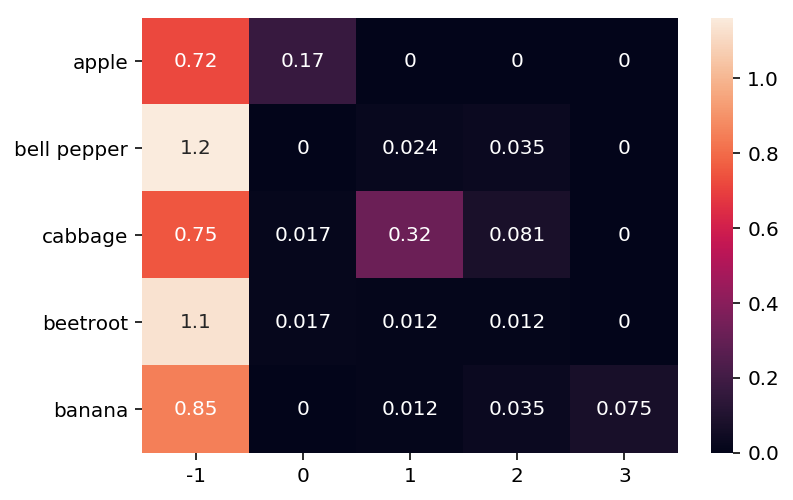

In [76]:
sns.heatmap(new_db_cluster_nat, annot = True)

## Spectral Clustering

In [53]:
sc_clusters

,1,2,3,4
apple,100,0,0,0
bell pepper,100,0,0,0
cabbage,97,0,0,0
beetroot,100,0,0,0
banana,93,2,1,1


In [54]:
sc_clusters_nat

,0,2,3,4
apple,59,0,0,0
bell pepper,84,0,0,0
cabbage,86,0,0,0
beetroot,80,0,0,0
banana,64,2,1,1


In [77]:
new_sc_cluster = normalize_df(sc_clusters)
new_sc_cluster

,0,1
apple,1.00,0.00
bell pepper,1.00,0.00
cabbage,0.97,0.00
beetroot,1.00,0.00
banana,0.95,0.02


In [78]:
new_sc_cluster_nat = normalize_df(sc_clusters_nat)
new_sc_cluster_nat

,1,2,3,4
apple,0.702381,0.000000,0.0000,0.000000
bell pepper,1.000000,0.000000,0.0000,0.000000
cabbage,1.023810,0.000000,0.0000,0.000000
beetroot,0.952381,0.000000,0.0000,0.000000
banana,0.761905,0.023256,0.0125,0.014706


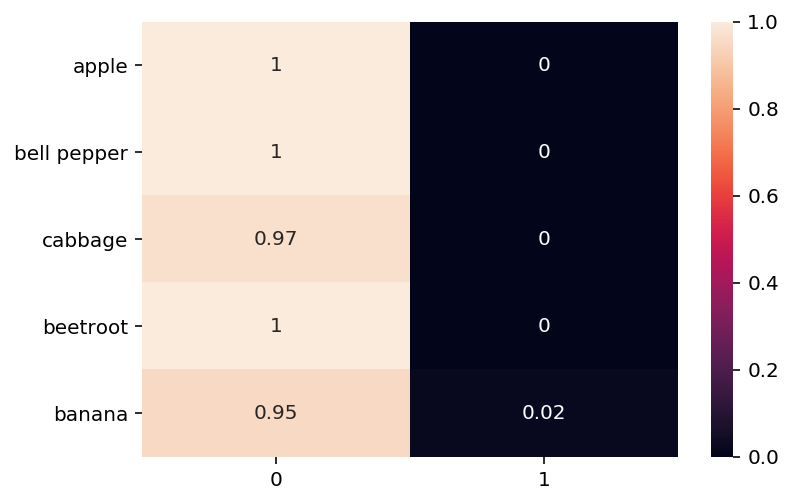

In [79]:
sns.heatmap(new_sc_cluster, annot = True)

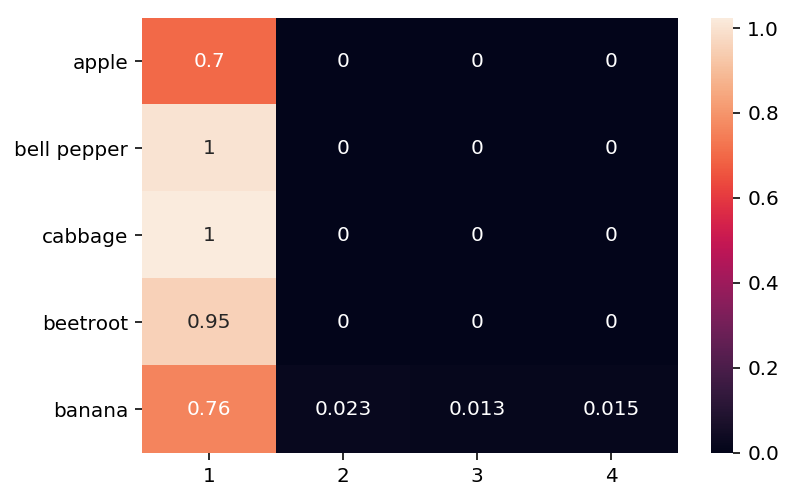

In [80]:
sns.heatmap(new_sc_cluster_nat, annot = True)

# Further PCA for DB Scan

In [16]:
master_blue_pca_obj, master_blue_transformed_nat = PCA_transform_channel(master_blue_nat, 10)

a_file = open('master_blue_natural_10.txt', 'w')

for row in master_blue_transformed_nat:
    np.savetxt(a_file, row)
    
a_file.close()

master_green_pca_obj, master_green_transformed_nat = PCA_transform_channel(master_green_nat, 10)

b_file = open('master_green_natural_10.txt', 'w')

for row in master_green_transformed_nat:
    np.savetxt(b_file, row)

b_file.close()

master_red_pca_obj, master_red_transformed_nat = PCA_transform_channel(master_red_nat, 10)

c_file = open('master_red_natural_10.txt', 'w')

for row in master_red_transformed_nat:
    np.savetxt(c_file, row)

c_file.close()

In [17]:
masters_transformed_nat = np.array([master_red_transformed_nat, master_green_transformed_nat, master_blue_transformed_nat])
masters_transformed_nat = np.transpose(masters_transformed_nat, (1, 2, 0))
np.save('./masters_transformed_natural_10', masters_transformed_nat)

In [20]:
masters_transformed_nat = np.load('./masters_transformed_natural_10.npy')

# 378 is the number of natural images 
transformed_flat_nat_10 = masters_transformed_nat.reshape((378, 10 * 3))

In [21]:
db_labels_nat_10, db_clusters_nat_10 = perform_clustering(transformed_flat_nat_10, 'db_scan')

Performing DB Scan
Error in processing file path:  ./processed_600px_train_natural//.DS_Store


In [23]:
db_clusters_nat_10

,-1,0
apple,2,57
bell pepper,10,74
cabbage,1,85
beetroot,3,77
banana,10,58
